# Isochrones - Nico Keeghan

In this notebook I will fit Girardi isochrones to a colour-magnitude plot of NGC 3293. This will allow me to determine an age of NGC 3293. The offset of the isochrone will allow me to determine the distance to NGC 3293 via the distance modulus.

We will start by importing the necessary libraries.

In [27]:
import numpy as np
import astropy
from astropy import units as u
import matplotlib.pyplot as plt 

We start by reading in the magnitudes that we have calculated.

In [28]:
from astropy.table import QTable

mags = QTable.read("obj_magnitudes.ecsv", format='ascii.ecsv')

We will plot the V-band magnitude as a function of the B-V colour for NGC 3293. This is essentially a HR-diagram.

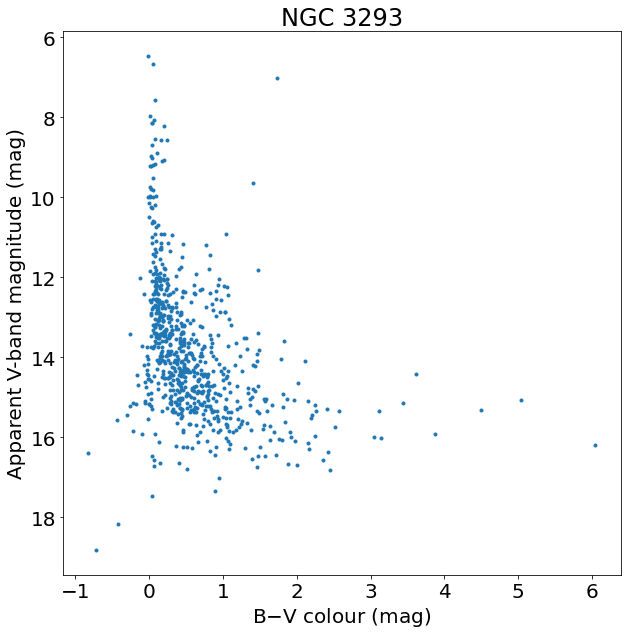

In [29]:
px = mags['Bmag'] - mags['Vmag']   # plot B-V colour on x-axis
py = mags['Vmag']               # plot V-band magnitude on y-axis

fig, ax = plt.subplots(figsize = (10,10))

plt.rcParams.update({'font.size': 20})
plt.plot(px, py, '.')
plt.xlabel('B$-$V colour (mag)')
plt.ylabel('Apparent V-band magnitude (mag)')
plt.title('NGC 3293')

# invert y-axis so brighter stars are at the top
ax.invert_yaxis()

plt.show()

***Figure 1.*** V-band magnitude as a function of B$-$V colour for stars in NGC 3293. The B$-$V colour is representative of stellar temperature, with a bluer colour (smaller B-V value) indicating a hotter star. Note that the y-axis has been reversed in order to resemble a HR diagram.

Reassuringly, Figure 1 looks very similar to Figure 9 in Preibisch et al (2017) (DOI:10.1051/0004-6361/201730874), which is also a plot of V-band magnitude against B-V colour for NGC 3293.

According to Preibisch et al (2017) (DOI:10.1051/0004-6361/201730874), the V-band dust extinction of NGC 3293 varies, with lower extinction near the cluster centre and greater extinction for stars further from the centre due to interstellar clouds. They suggest that for the central region of the cluster, $A_v \approx 1$ mag. As such, we will adopt $A_v = 1$ mag. Using a standard Galactic reddening law of $A_V = 3.1 E(B − V )$ as in Dufton et al (2006) (10.1051/0004-6361:20065392), we have $E(B-V) =\approx 1/3.1$ for NGC 3293.

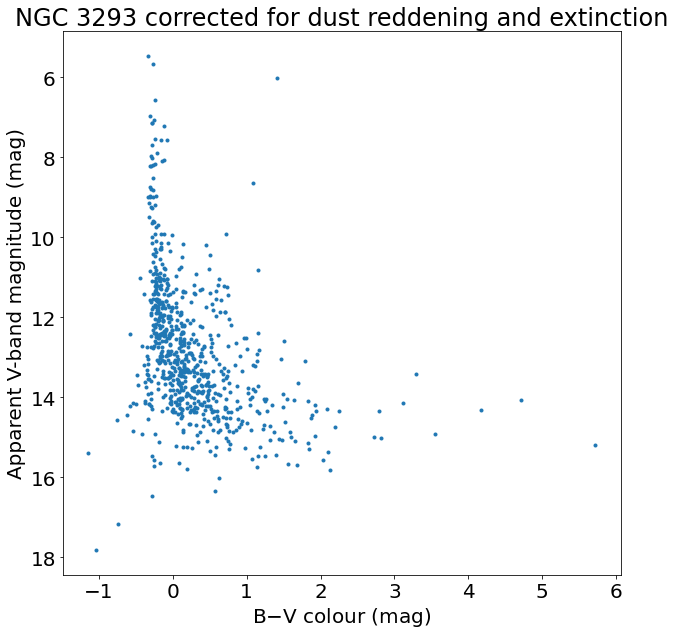

In [30]:
extinction = 1
reddening = extinction/3.1

px = mags['Bmag'] - mags['Vmag'] - reddening   # plot B-V colour on x-axis
py = mags['Vmag'] - extinction                 # plot V-band magnitude on y-axis

fig, ax = plt.subplots(figsize = (10,10))

plt.rcParams.update({'font.size': 20})
plt.plot(px, py, '.')
plt.xlabel('B$-$V colour (mag)')
plt.ylabel('Apparent V-band magnitude (mag)')
plt.title('NGC 3293 corrected for dust reddening and extinction')

# invert y-axis so brighter stars are at the top
ax.invert_yaxis()

plt.show()

***Figure 2.*** Plot of V-band magnitude as a function of B$-$V colour for NGC 3293, shown as small blue dots. Corrections have been made for dust extinction and reddening, with $A_V = 1$ and $E(B-V) = 1/3.1$. These corrections shift the stars upward, to brighter values, and to the left, to bluer values, respectively.

We will now match isochrones to this plot of NGC 3293 to determine its age. I generated Girardi isochrones for a range of ages from 10 Myr to 100 Myr, using http://stev.oapd.inaf.it/cgi-bin/cmd_3.6. Since we are investigating an open cluster, there is no need to investigate any ages greater than this.

First I will create a class to store each isochrone, borrowing from the Girardi_UBVRI.ipynb file on Moodle.

In [31]:
# Code adapted from Girardi_UBVRI.ipynb on Moodle

class isochroneclass:
    def __init__(self):
            self.filename = "NULL                            "      # Relevant filename
            self.age = -99.0                                        # Age (log)
            self.m = []                                   # Star masses
            self.U = []                                   # Star U-band magnitudes
            self.B = []                                   # Star B-band magnitudes
            self.V = []                                   # Star V-band magnitudes
            self.R = []                                   # Star R-band magnitudes
            self.I = []                                   # Star I-band magnitudes

Now I will read in the generated isochrones. I store the isochrones in a dictionary, indexe by log(age).

In [32]:
# Adapted from Girardi_UBVRI.ipynb on Moodle

fname = 'isochrones/output545039620091_1e7_1e8.dat'
isochrones = {}


f=open(fname,"r")
lines=f.readlines()

curr_age = -99.0

# iterate through lines of data file and add relevant information to ic object
for x in lines:
    if x[0]!='#':
        split_line = x.split()
        age = float(split_line[2])
        if age != curr_age:
            if curr_age > -99.0:
                isochrones[curr_age] = ic
            ic=isochroneclass()               # create new ic class
            curr_age = age                    # update current age
            ic.age = curr_age                 # set age for new isochrone
        ic.m.append(float(split_line[5]))     # mass of star
        ic.U.append(float(split_line[28]))    # U-band magnitude
        ic.B.append(float(split_line[29]))    # B-band magnitude
        ic.V.append(float(split_line[30]))    # V-band magnitude
        ic.R.append(float(split_line[31]))    # R-band magnitude
        ic.I.append(float(split_line[32]))    # I-band magnitude
        
isochrones[curr_age] = ic

f.close()


print('Ages:')
for key in isochrones:
    print('%.2e' % 10**isochrones[key].age)

print("")
print('Check that the first line of', fname, 'agrees with these values')
print(isochrones[7.0].m[0])
print(isochrones[7.0].U[0])
print(isochrones[7.0].B[0])
print(isochrones[7.0].V[0])
print(isochrones[7.0].R[0])
print(isochrones[7.0].I[0])



Ages:
1.00e+07
2.00e+07
3.00e+07
4.00e+07
5.00e+07
6.00e+07
7.00e+07
8.00e+07
9.00e+07
1.00e+08

Check that the first line of isochrones/output545039620091_1e7_1e8.dat agrees with these values
0.09
17.204
15.776
14.3
12.452
10.358


We can see that we have read in all of the ages. The first line of the file matches the printed values, so it looks like everything has been read in correctly.

Now that we have read these in, we need to plot the isochrones. We will use an offset to adjust for distance by lining up the main sequence of the isochrones to the main sequence of NGC 3293. By eye, an offset of 12 mag seems to line the main sequence of the isochrones up with the main sequence of NGC 3293 quite well. I can fine-tune this a bit more if necessary once a find a suitable age.

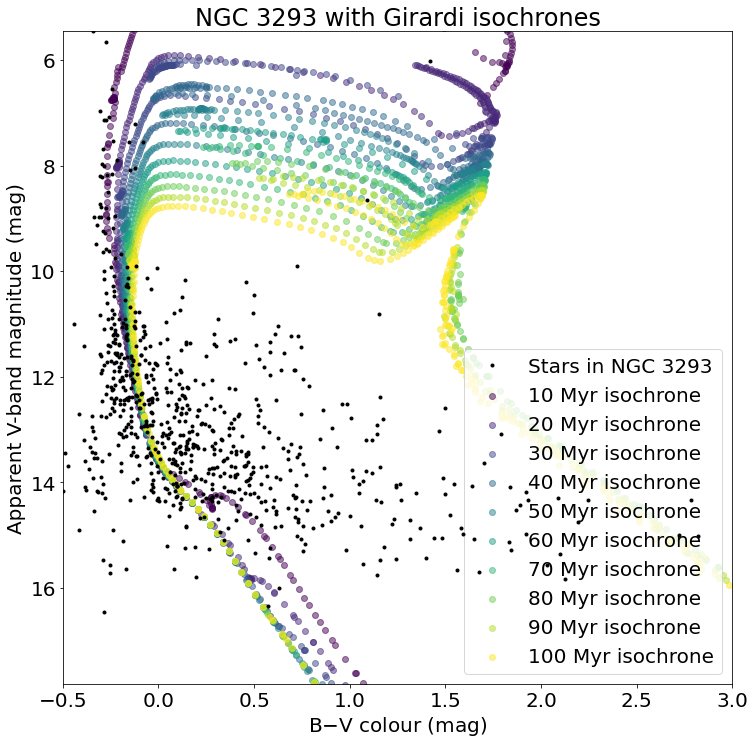

In [33]:
offset = 12

# get some sequential colors to plot with to easily see the differences due to age
from matplotlib import cm
colors = cm.viridis(np.linspace(0,1,len(isochrones.keys())))

fig, ax = plt.subplots(figsize = (12,12))

plt.rcParams.update({'font.size': 20})
plt.plot(px, py, '.', color='black',label='Stars in NGC 3293',zorder=10)

for age,color in zip(isochrones.keys(),colors):
    BV=np.array(isochrones[age].B)-np.array(isochrones[age].V)
    offsetV = np.array(isochrones[age].V) + offset

    plt.scatter(BV, offsetV, color=color, label='{:.0f} Myr isochrone'.format(10**(isochrones[age].age-6)),alpha=0.5)

plt.xlabel('B$-$V colour (mag)')
plt.ylabel('Apparent V-band magnitude (mag)')
plt.title('NGC 3293 with Girardi isochrones')

# set y-axis limits so we can see the stars
plt.ylim(min(py),max(py))
plt.xlim(-0.5,3)

# invert y-axis so brighter stars are at the top
ax.invert_yaxis()

plt.legend(loc='lower right')

plt.show()

***Figure 3.*** Plot of V-band magnitude as a function of B$-$V colour for NGC 3293, shown as small black dots. Corrections have been made for dust extinction and reddening. Giradi isochrones corresponding to ages of 10 Myr to 100 Myr in increments of 10 Myr have been plotted with large dots, from dark purple to yellow with increasing age. The isochrones have been vertically offset by 12 magnitudes by visual inspection to match up the isochrones with the main sequence of NGC 3293. The turn off point of the isochrones for ages greater than 20 Myr appear to be too low for NGC 3293, suggesting that NGC 3293 is at most 20 Myr old. The isochrones were generated by CMD 3.6 (http://stev.oapd.inaf.it/cmd).

From this plot we can see that the main sequence of NGC 3293 extends into bright (low-valued) V-band magnitudes, suggesting that the isochrones for ages of 30 Myr and greater are not good fits to the data.

As such, we will focus on the isochrones with ages of 20 Myr or less. We generated more isochrones in the range 1 Myr to 15 Myr, again using http://stev.oapd.inaf.it/cgi-bin/cmd_3.6.

In [34]:
# Adapted from Girardi_UBVRI.ipynb on Moodle

fname = 'isochrones/output410618231006_1e6_to_15e6.dat'


f=open(fname,"r")
lines=f.readlines()

curr_age = -99.0

# iterate through lines of data file and add relevant information to ic object
for x in lines:
    if x[0]!='#':
        split_line = x.split()
        age = float(split_line[2])
        if age != curr_age:
            if curr_age > -99.0:
                isochrones[curr_age] = ic
            ic=isochroneclass()               # create new ic class
            curr_age = age                    # update current age
            ic.age = curr_age                 # set age for new isochrone
        ic.m.append(float(split_line[5]))     # mass of star
        ic.U.append(float(split_line[28]))    # U-band magnitude
        ic.B.append(float(split_line[29]))    # B-band magnitude
        ic.V.append(float(split_line[30]))    # V-band magnitude
        ic.R.append(float(split_line[31]))    # R-band magnitude
        ic.I.append(float(split_line[32]))    # I-band magnitude
        
isochrones[curr_age] = ic

f.close()


print('Ages:')
for key in isochrones:
    print('%.2e' % 10**isochrones[key].age)

print("")
print('Check that the first line of', fname, 'agrees with these values')
print(isochrones[6.0].m[0])
print(isochrones[6.0].U[0])
print(isochrones[6.0].B[0])
print(isochrones[6.0].V[0])
print(isochrones[6.0].R[0])
print(isochrones[6.0].I[0])



Ages:
1.00e+07
2.00e+07
3.00e+07
4.00e+07
5.00e+07
6.00e+07
7.00e+07
8.00e+07
9.00e+07
1.00e+08
1.00e+06
3.00e+06
5.00e+06
7.00e+06
9.00e+06
1.10e+07
1.30e+07
1.50e+07

Check that the first line of isochrones/output410618231006_1e6_to_15e6.dat agrees with these values
0.09
14.086
13.075
11.729
10.124
8.225


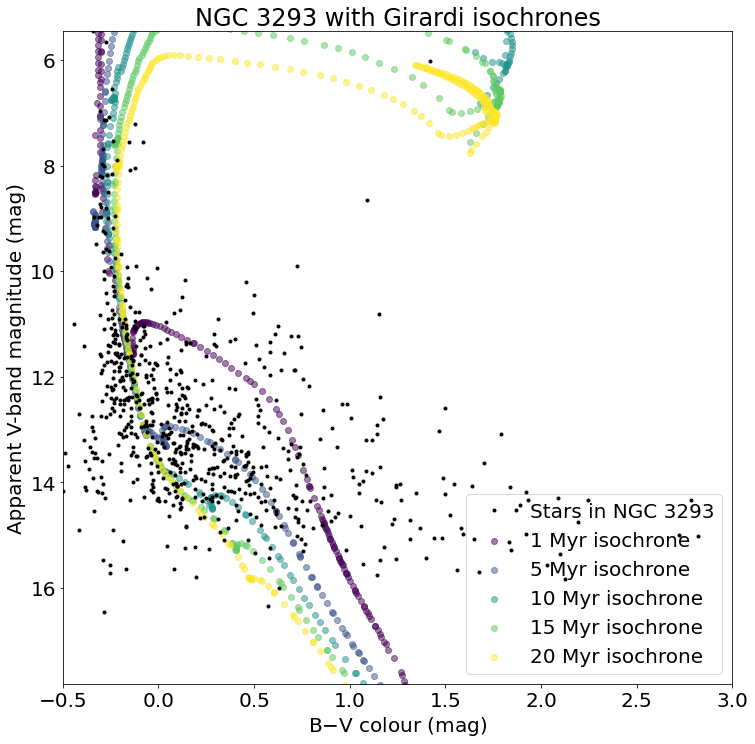

In [35]:
offset = 12

# isochrones of log(age) that we are interested in, corresponding to age = 1, 5, 10, 15, 20 Myr.
ages = [6.0,6.69897,7.0,7.17609,7.30103]

# get some sequential colors to plot with to easily see the differences due to age
colors = cm.viridis(np.linspace(0,1,len(ages)))

fig, ax = plt.subplots(figsize = (12,12))

plt.rcParams.update({'font.size': 20})
plt.plot(px, py, '.', color='black',label='Stars in NGC 3293',zorder=10)

for age,color in zip(ages,colors):
    BV=np.array(isochrones[age].B)-np.array(isochrones[age].V)
    offsetV = np.array(isochrones[age].V) + offset

    plt.scatter(BV, offsetV, color=color, label='{:.0f} Myr isochrone'.format(10**(isochrones[age].age-6)),alpha=0.5)

plt.xlabel('B$-$V colour (mag)')
plt.ylabel('Apparent V-band magnitude (mag)')
plt.title('NGC 3293 with Girardi isochrones')

# set y-axis limits so we can see the stars
plt.ylim(min(py),max(py))
plt.xlim(-0.5,3)

# invert y-axis so brighter stars are at the top
ax.invert_yaxis()

plt.legend(loc='lower right')

plt.show()

***Figure 4.*** Plot of V-band magnitude as a function of B$-$V colour for NGC 3293, shown as small black dots. Corrections have been made for dust extinction and reddening. Giradi isochrones corresponding to ages of 1, 5, 10, 15, and 20 Myr have been plotted with large dots, from dark purple to yellow with increasing age. The isochrones have been vertically offset by 12 magnitudes by visual inspection to match up the isochrones with the main sequence of NGC 3293. The isochrones were generated by CMD 3.6 (http://stev.oapd.inaf.it/cmd).

The 1 Myr isochrone has a distinct dip at $B-V \approx 0$ mag, followe by an upward arc as $B-V$ color increases. This does not match the stars in NGC 3293. Further, even when the offset is varied, the 20 Myr isochrone has a slope that is too steep to match with the main sequence of NGC 3293. Rather, the distribution of stars in NGC 3293 seems to follow more closely to the 5, 10, and 15 Myr isochrones.

We will now plot isochrones for ages between 5 and 15 Myr. We already generated these above.

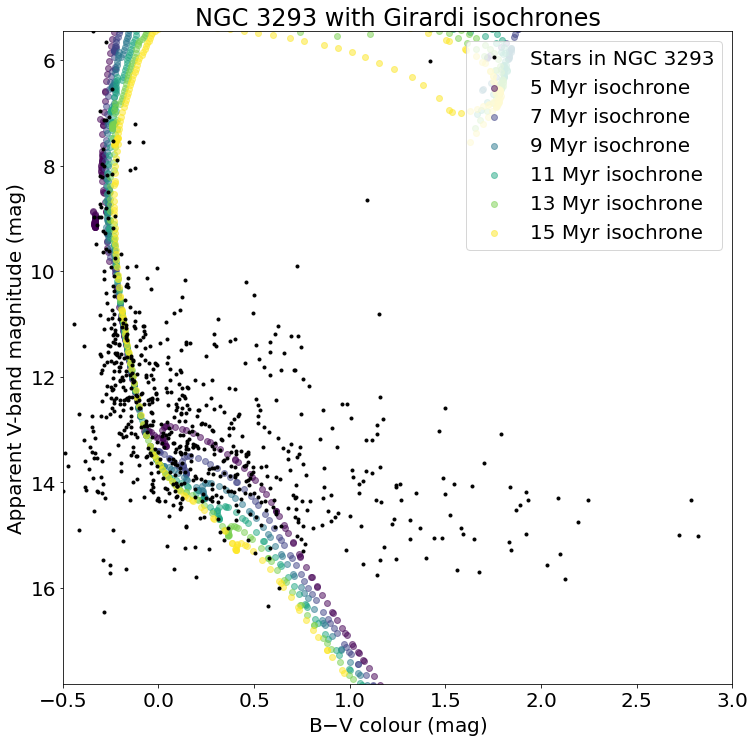

In [36]:
offset = 12

# isochrones of log(age) that we are interested in, corresponding to ages between 5 and 15 Myr.
ages = [6.69897, 6.8451, 6.95424, 7.04139, 7.11394, 7.17609]

# get some sequential colors to plot with to easily see the differences due to age
colors = cm.viridis(np.linspace(0,1,len(ages)))

fig, ax = plt.subplots(figsize = (12,12))

plt.rcParams.update({'font.size': 20})
plt.plot(px, py, '.', color='black',label='Stars in NGC 3293',zorder=10)

for age,color in zip(ages,colors):
    BV=np.array(isochrones[age].B)-np.array(isochrones[age].V)
    offsetV = np.array(isochrones[age].V) + offset

    plt.scatter(BV, offsetV, color=color, label='{:.0f} Myr isochrone'.format(10**(isochrones[age].age-6)),alpha=0.5)

plt.xlabel('B$-$V colour (mag)')
plt.ylabel('Apparent V-band magnitude (mag)')
plt.title('NGC 3293 with Girardi isochrones')

# set y-axis limits so we can see the stars
plt.ylim(min(py),max(py))
plt.xlim(-0.5,3)

# invert y-axis so brighter stars are at the top
ax.invert_yaxis()

plt.legend(loc='upper right')

plt.show()

***Figure 5.*** Plot of V-band magnitude as a function of B$-$V colour for NGC 3293, shown as small black dots. Corrections have been made for dust extinction and reddening. Giradi isochrones corresponding to ages of 5 to 15 Myr, in increments of 2 Myr, have been plotted with large dots, from dark purple to yellow with increasing age. The isochrones have been vertically offset by 12 magnitudes by visual inspection to match up the isochrones with the main sequence of NGC 3293. The isochrones were generated by CMD 3.6 (http://stev.oapd.inaf.it/cmd).

The age is difficult to pinpoint exactly, but by plotting the isochrones individually and playing around with the offset a little, the best fit appears to be at about 9 Myr.

Using the 9 Myr isochrone, I will now implement a few different offsets to try to pinpoint the best one.

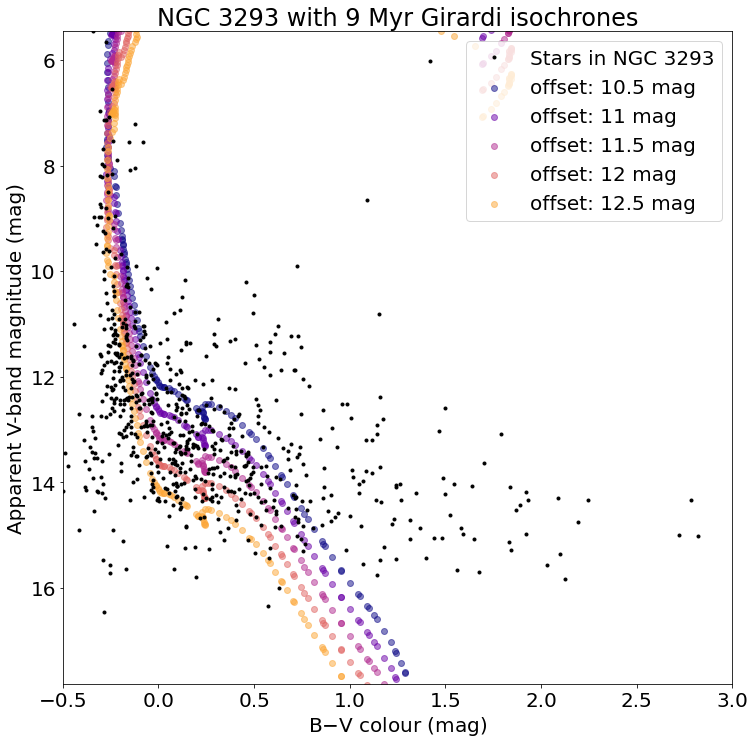

In [37]:
offsets = [10.5,11,11.5,12,12.5]

# isochrone of age = 9 Myr (10**age = 9*10**6).
age = 6.95424

# get some sequential colors to plot with to easily see the differences due to offset
colors = cm.plasma(np.linspace(0,1,len(offsets)+1))

fig, ax = plt.subplots(figsize = (12,12))

plt.rcParams.update({'font.size': 20})
plt.plot(px, py, '.', color='black',label='Stars in NGC 3293',zorder=10)

for offset,color in zip(offsets,colors):
    BV=np.array(isochrones[age].B)-np.array(isochrones[age].V)
    offsetV = np.array(isochrones[age].V) + offset

    plt.scatter(BV, offsetV, color=color, label='offset: {offset} mag'.format(offset=offset),alpha=0.5)

plt.xlabel('B$-$V colour (mag)')
plt.ylabel('Apparent V-band magnitude (mag)')
plt.title('NGC 3293 with 9 Myr Girardi isochrones')

# set y-axis limits so we can see the stars
plt.ylim(min(py),max(py))
plt.xlim(-0.5,3)

# invert y-axis so brighter stars are at the top
ax.invert_yaxis()

plt.legend(loc='upper right')

plt.show()

***Figure 6.*** Plot of V-band magnitude as a function of B$-$V colour for NGC 3293, shown as small black dots. Corrections have been made for dust extinction and reddening. Giradi isochrones corresponding to an age of 9 Myr have been plotted with large dots, with offsets ranging from 10.5 mag to 12.5 mag in increments of 0.5 mag, from dark purple to orange with increasing value. The isochrone was generated by CMD 3.6 (http://stev.oapd.inaf.it/cmd).

The offsets of 11.5 mag and 12 mag look the best, so I adjusted the offset in this range and settled on 11.8 mag as the best offset. This seems to match the upper main sequence very well, and mimic the curve in the main sequence from 12 mag to 14 mag.

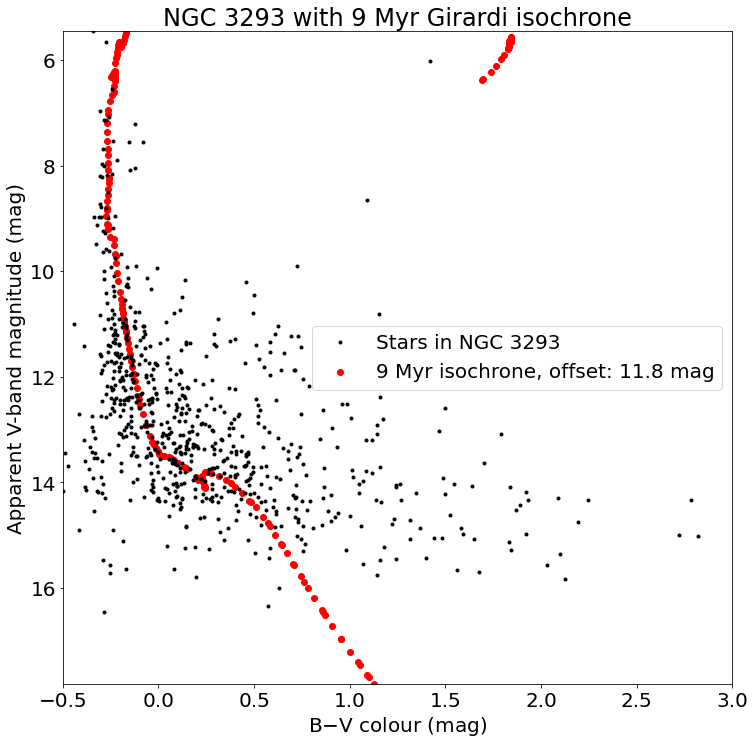

In [38]:
offset = 11.8

# isochrone of age = 9 Myr (10**age = 9*10**6).
age = 6.95424

fig, ax = plt.subplots(figsize = (12,12))

plt.rcParams.update({'font.size': 20})
plt.plot(px, py, '.', color='black',label='Stars in NGC 3293',zorder=10)


BV=np.array(isochrones[age].B)-np.array(isochrones[age].V)
offsetV = np.array(isochrones[age].V) + offset

plt.scatter(BV, offsetV, color='red', label='{:.0f} Myr isochrone, offset: {:.1f} mag'.format(10**(age-6),offset))

plt.xlabel('B$-$V colour (mag)')
plt.ylabel('Apparent V-band magnitude (mag)')
plt.title('NGC 3293 with 9 Myr Girardi isochrone')

# set y-axis limits so we can see the stars
plt.ylim(min(py),max(py))
plt.xlim(-0.5,3)

# invert y-axis so brighter stars are at the top
ax.invert_yaxis()

plt.legend()

plt.show()

***Figure 7.*** Plot of V-band magnitude as a function of B$-$V colour for NGC 3293, shown as small black dots. Corrections have been made for dust extinction and reddening. A Giradi isochrone corresponding to an age of 9 Myr has been plotted with large red dots. The isochrone has been vertically offset by 11.8 magnitudes by visual inspection to match up the isochrone with the main sequence of NGC 3293. The isochrone matches well with the upper end of the main sequence, and the curve at $B-V\approx 0$ also matches the distribution of stars well. Stars on the far right of the diagram are likely to be foreground stars, as they are cool red stars that likely would not be bright enough to be detected if they were at the same distance as NGC 3293. The isochrone was generated by CMD 3.6 (http://stev.oapd.inaf.it/cmd).

So we find that an offset of 11.8 mag fits the main sequence of NGC 3293 the best. If $m$ denotes the V-band apparent magnitude of the isochrone model stars, and $M$ the V-band absolute magnitude, this means that $m = M + 11.8$.

Using this offset, we can use the distance modulus,
$$m = M + 5\log\left(\frac{D}{10 \text{pc}}\right),$$
to determine the distance $D$ to NGC 3293.

Rearranging the equation and substituting in the offset for the isochrone gives
$$
\begin{align}
D &= 10^{(m - M)/5} \times 10 \text{ pc}\\
&= 10^{11.8/5} \times 10 \text{ pc}\\
&\approx 2291 \text{ pc}
\end{align}
$$

So, using the 9 Myr isochrone and an offset of 11.8 mag, the distance to NGC 3293 is approximately 2.3 kpc.

Bisht et al (2021) (DOI:10.1093/mnras/stab691) also used isochrone fitting to determine the age and distance to NGC 3293. They found an age of $12 \pm 2$ Myr, and a distance of $2.6 \pm 0.1$ kpc. These suggest that my calculations of an age of $9 \pm 4$ Myr and a distance of $2.3$ kpc are within the right ballpark. A reason for the discrepancy could be that Bisht et al (2021) used the J, H, and K bands in the near-infrared, which are less subject to extinction from gas and dust.

### Filtering for Cluster Objects [CEDRIC LIANG] 

The isochrone fit has indicated that there are a great deal of stars that the detection algorithm has picked up on that don't seem to be in the cluster - their B-V colours don't match with their expected computed V band magnitudes compared to the rest of the stars in the cluster.

As such, we'll need to find a way to get rid of these stars. One approach would to be play around with the threshold of the star detection algorithm, hoping that less background 'distractions' are picked up. However, this approach has its problems, in that it affects the detection of the stars *within* our cluster in an uneven manner.

We can foresee a situation where we lose more low mass stars within our cluster than high mass stars, whereas background stars that are sufficiently luminant as to be captured by the algorithm might still be shown on our HR diagram, even though their temperatures are far too blue for their magnitudes.

As such, we'll take a second approach. Given that our object is an open cluster (which should have uniform age), we'll use the isochrone as an authority on the open cluster's age and distance and get rid of any stars that don't fall near the isochrone on the HR diagram.

This can be done by Iterating over our stars and calculating the Cartesian distance to the closest point on the isochrone.

#### Scaling + Coordinate Transformation

Given that the axes of our chart occupy different orders of magnitude with different scaling, we can't just use the Euclidean distance directly. It'll be far more sensitive to deviations from the isochrone in the magnitude value than the colour value. 

As such, we'll need to scale one of the domains to the other's domain such that we have a 'square' plot of some derived quantity with equal scaling to the other. Selecting this transformation factor is a qualitative process - we'll just have to pick it such that it feels 'right'.

We'll say that we're happy with the plots when the range of the colour axis is set to [-0.5, 3.0] and the V-band magnitude axis is set to [5.5, 18]. These don't have to be exact since our transformation doesn't 'cut' any data off, only stretches it.

We'll then scale our colour axis up to match the range of the V-band magnitude. It doesn't matter which we pick, but I'd rather work with larger values to minimise the impact of floating point errors. It's not a big deal.

In [39]:
# stars: px, py
# isochrone: BV, offsetV

colour_range = (-0.5, 3.0)
vmag_range = (5.5, 18)


def transform_colour(bv):
    # colour index's relative position between -0.5 and 3.0
    relative_position = (bv-colour_range[0])/(colour_range[1]-colour_range[0])
    # use relative position to calculate colour in vmag scale
    return relative_position*(vmag_range[1]-vmag_range[0]) + vmag_range[0]


We're working entirely with abstract derived quantities now, but they don't need to have meaning in order for us to define some threshold 'distance' from the isochrone.

Now we'll need to apply this x-coordinate transformation to both our stars and our isochrone.

In [40]:
px_t = list(map(transform_colour, px))
bv_t = list(map(transform_colour, BV))

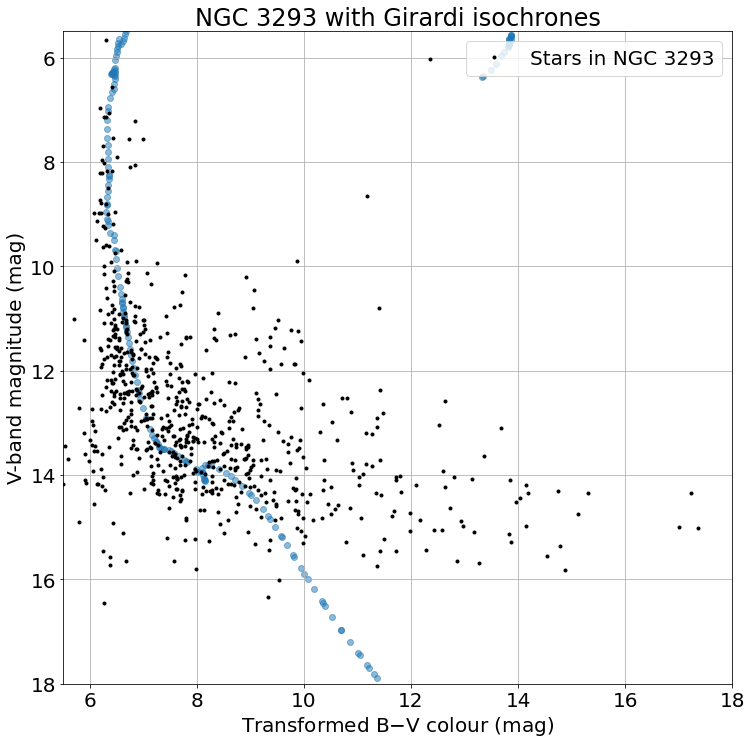

In [41]:
fig, ax = plt.subplots(figsize = (12,12))
plt.rcParams.update({'font.size': 20})
plt.plot(px_t, py, '.', color='black',label='Stars in NGC 3293',zorder=10)
plt.scatter(bv_t, offsetV, alpha=0.5)

plt.xlabel('Transformed B$-$V colour (mag)')
plt.ylabel('V-band magnitude (mag)')
plt.title('NGC 3293 with Girardi isochrones')


# set y-axis limits so we can see the stars
plt.ylim(vmag_range)
plt.xlim(vmag_range)

# invert y-axis so brighter stars are at the top
ax.invert_yaxis()

plt.legend(loc='upper right')
plt.grid(True)
plt.show()


***Figure 8.*** Plot of stars in NGC3293 after a linear transformation on the $x$ axis that transforms scaling such that a B-V range of [-0.5, 3.0] corresponds to [5.5, 18] in the new coordinate system. 

We have our transformed coordinates. It doesn't matter that our v-band magnitude is upside down - the fact we're using a square grid now means that our Euclidean distance values will be valid.

Now let's define our distance calculation.

In [42]:
from functools import partial 

# calculates euclidean distance between two points
def euclid_dist(x1, y1, x2, y2):
    return np.linalg.norm(np.array([x2, y2])-np.array([x1, y1]))


# gets the minimum distance from a point to a list of points
def min_euclid_dist(xlist, ylist, single_x, single_y):
    dist = partial(euclid_dist, single_x, single_y)
    return min(map(dist, xlist, ylist))


In [43]:
# partially applied function that sets the xlist and ylist of our min_euclid_dist to the constant values of our isochrone
star_dist = partial(min_euclid_dist, bv_t, offsetV)

Let's test this transformation function for a hypothetical star at transformed coordinate (11, 16).

In [44]:
#sample distance to isochrone
star_dist(11, 16)

0.7873513594738435

This looks good! Now we'll apply this filter to our data points. There's also a subjective part - experiementing with thresholds for what reasonable distances should look like. 

In [45]:
# returns the new px_t, py pairs of stars below the threshold, as well as indices of the stars that were above and thus removed
def exceeding_indices(px, py, threshold_dist):
    removed_stars = [idx for idx, tup in enumerate(zip(px_t, py)) if star_dist(tup[0], tup[1]) > threshold_dist]
    filtpx = [x for idx, x in enumerate(px) if idx not in removed_stars]
    filtpy = [y for idx, y in enumerate(py) if idx not in removed_stars]
    return removed_stars, filtpx, filtpy


In [46]:
threshold_1 = 1
threshold_2 = 1.3

Apply a filter for thresholds of 1 and 1.3 respectively removes the following amount of objects from our data.

In [47]:
removed_stars, filtpx_t, filtpy = exceeding_indices(px_t, py, threshold_1)
removed_stars_2, filtpx_t_2, filtpy_2 = exceeding_indices(px_t, py, threshold_2)

print(len(removed_stars))
print(len(removed_stars_2))

208
152


We can plot the resulting HR diagram with our pre-transformation quantities, since the transformation has done its job in filtration.

In [48]:
filtpx = [x for idx, x in enumerate(px) if idx not in removed_stars]


looser_filt = set(removed_stars) - set(removed_stars_2)
looser_filtpx = [x for idx, x in enumerate(px) if idx in looser_filt]
looser_filtpy = [y for idx, y in enumerate(py) if idx in looser_filt]



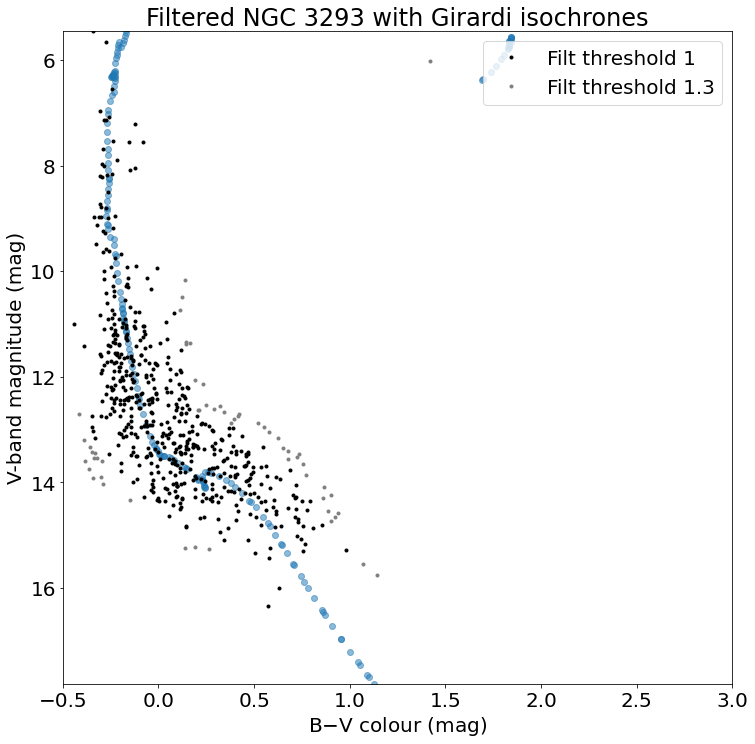

In [49]:
fig, ax = plt.subplots(figsize=(12, 12))
plt.rcParams.update({'font.size': 20})
plt.plot(filtpx, filtpy, '.', color='black', label=f'Filt threshold {threshold_1}', zorder=10)
plt.plot(looser_filtpx, looser_filtpy, '.', color='grey', label=f'Filt threshold {threshold_2}', zorder=10)
plt.scatter(BV, offsetV, alpha=0.5)

plt.xlabel('B$-$V colour (mag)')
plt.ylabel('V-band magnitude (mag)')
plt.title('Filtered NGC 3293 with Girardi isochrones')


# set y-axis limits so we can see the stars
plt.ylim(min(py), max(py))
plt.xlim(-0.5, 3)

# invert y-axis so brighter stars are at the top
ax.invert_yaxis()

plt.legend(loc='upper right')

plt.show()


***Figure 9.*** Filtered HR plot of stars in NGC3293 after threshold Euclidean distances in transformed coordinates of 1 and 1.3 were applied. The transformed coordinates were only used for the purposes of filtration - we can take the list of discarded stars and remove these entries from the original dataset, allowing us to generate the HR diagram of selected stars without transformation.

This looks good! In terms of selecting a value, I'm happy to use the looser filtration 1.3, since it appears to include the single evolved giant star near the end of the isochrone's evolutionary track. Let's now write this list of removed stars to file.

In [51]:
import json
index_to_id = [row['id'] for row in mags]
removed_ids = [int(index_to_id[idx]) for idx in removed_stars_2]

print(removed_ids)
with open('removed_ids.dat', 'w') as f:
    json.dump(removed_ids, f, indent=4)

[2, 9, 15, 16, 23, 27, 32, 34, 43, 60, 62, 64, 68, 83, 95, 99, 110, 113, 118, 120, 121, 124, 128, 136, 139, 149, 150, 161, 167, 170, 176, 181, 190, 195, 203, 212, 220, 225, 230, 232, 245, 250, 251, 252, 258, 273, 275, 283, 292, 299, 302, 313, 316, 322, 325, 330, 345, 362, 364, 369, 375, 385, 387, 393, 395, 398, 399, 408, 413, 419, 421, 422, 428, 434, 439, 448, 454, 459, 462, 463, 474, 483, 484, 486, 495, 496, 535, 536, 540, 547, 548, 552, 557, 561, 563, 566, 567, 570, 573, 576, 582, 593, 594, 599, 600, 603, 622, 627, 630, 631, 632, 634, 637, 639, 640, 646, 648, 656, 657, 673, 676, 682, 683, 687, 688, 690, 692, 693, 698, 699, 700, 706, 710, 716, 726, 727, 738, 740, 741, 759, 761, 765, 768, 771, 777, 779, 783, 784, 796, 802, 809, 810]
